In [1]:
import contextlib
import math
import random
import numpy as np
from csv import DictReader
from functools import cached_property
from typing import Iterable, Callable, Sequence

from matplotlib import pyplot as plt


class logger:  # noqa
    # Fake logger
    log = staticmethod(print)

In [2]:
import doctest
from abc import ABC, abstractmethod
from collections import defaultdict, Counter


class AbstractSerialMapper(ABC):

    NOTHING = object()

    def __init__(self):
        self._data = []

    @abstractmethod
    def add(self, value, *args, **kwargs):
        pass

    def __len__(self):
        return len(self._data)

    def __getitem__(self, key):
        with contextlib.suppress(IndexError):
            return self._data[key]

    def __iter__(self):
        """Iterates through the indices from 0 to len(self._data)"""
        return iter(range(self.__len__()))


class SerialUnidirectionalMapper(AbstractSerialMapper):
    def __init__(self):
        super().__init__()

    def add(self, data, *args, key=None, **kwargs):
        if key is None:
            self._data.append([] if data is self.NOTHING else [data])
        else:
            self._data[key].append(data)


class SerialBidirectionalMapper(AbstractSerialMapper):

    def __init__(self):
        super().__init__()
        self._data = []
        self._inverse_data = defaultdict(lambda: None)

    def __getitem__(self, key):
        return self._data[key]

    def add(self, data, *args, **kwargs):
        self._inverse_data[data] = len(self._data)
        self._data.append(data)

    @property
    def inverse(self):
        """
        Data to index mapping
        """
        return self._inverse_data


class InMemory2DIndexer(object):
    """
    An in-memory 2D indexer for efficiently store users, items and their related data from a CSV file.

    This class provides an efficient mechanism to map and store large datasets
    using bijective mappings between user/item names and their corresponding IDs.

    Example usage:
        >>> # Testing the creation of an in-memory 2D indexer
        >>> InMemory2DIndexer.create_from_csv(
        ...     file_path="./ml-32m/ratings.csv",
        ...     user_header="userId",
        ...     item_header="movieId",
        ...     limit=10
        ... )  # doctest:+ELLIPSIS
        Limit of entries (.i.e 10) to load has been reached. Exiting without loading the rest...
        <__main__.InMemory2DIndexer object at ...
        >>> # Testing that we can load data effectively
        >>> indexed_data = InMemory2DIndexer.create_from_csv(
        ...     file_path="./ml-32m/ratings.csv",
        ...     user_header="userId",
        ...     item_header="movieId",
        ...     limit=400
        ... )  # doctest:+ELLIPSIS
        Limit of entries (.i.e 400) to load has been reached. Exiting without loading the rest...
        >>> # Testing the content of the indexed_data
        >>> # Expect `users_count` to be 5 for the 400th lines indexed
        >>> indexed_data.users_count == 5
        True
        >>> # Expect `items_count` to be 327 for the 400th lines indexed
        >>> indexed_data.items_count == 327
        True
        >>> indexed_data.id_to_user_bmap._data
        ['1', '2', '3', '4', '5']
    """

    LIMIT_TO_LOAD_IN_MEMORY = 1_000_000_000_000

    def __init__(self):
        self.id_to_item_bmap = SerialBidirectionalMapper()  # bijective mapping
        self.id_to_user_bmap = SerialBidirectionalMapper()
        self.data_by_user_id = SerialUnidirectionalMapper()  # subjective mapping
        self.data_by_item_id = SerialUnidirectionalMapper()

    def _construct_data(self, data, items):  # noqa
        return (
            self._data_constructor(data, items)
            if self._data_constructor is not None
            else data
        )

    def _initialize_extra_attributes(
        self,
        *,
        user_header: str,
        item_header: str,
        file_path: str,
        data_headers: Iterable = None,
        data_constructor: Callable = None,
        limit: int = None,
        verbose: bool = False,
    ):
        self._user_header = user_header
        self._item_header = item_header
        self._file_path = file_path
        self._verbose = verbose
        self._data_headers = data_headers
        self._data_constructor = data_constructor
        self._limit = limit or self.LIMIT_TO_LOAD_IN_MEMORY

    @classmethod
    def create_from_csv(
        cls,
        *,
        file_path: str,
        user_header: str,
        item_header: str,
        data_headers: Iterable = None,
        data_constructor: Callable = None,
        limit: int = None,
        verbose: bool = False,
    ) -> "InMemory2DIndexer":

        self = cls()
        self._initialize_extra_attributes(
            user_header=user_header,
            item_header=item_header,
            file_path=file_path,
            data_headers=data_headers,
            data_constructor=data_constructor,
            limit=limit,
            verbose=verbose,
        )

        indexed_count = 0

        try:
            with open(file_path, mode="r", newline="") as csvfile:
                for line_count, line in enumerate(DictReader(csvfile)):
                    user, item = line[self._user_header], line[self._item_header]
                    # Unlikely in this dataset but better have this guard
                    if not all([user, item]):
                        logger.log(
                            f"Cannot process the line {line_count}, cause expects `user` and `item` to be defined but got {user} and {item} for them respectively, skipping..."
                        )
                        continue

                    user_id = self.id_to_user_bmap.inverse[user]
                    item_id = self.id_to_item_bmap.inverse[item]

                    if user_id is None:
                        # This user is a new one, so add it
                        self.id_to_user_bmap.add(user)

                    if item_id is None:
                        # This item is a new one, so add it
                        self.id_to_item_bmap.add(item)

                    # Add the data without the useless items for indexing
                    data = self._construct_data(line, data_headers)

                    self.data_by_user_id.add(data=data, key=user_id)
                    self.data_by_item_id.add(data=data, key=item_id)

                    if verbose:
                        logger.log(
                            f"Indexed the line {indexed_count} of {file_path} successfully"
                        )

                    indexed_count += 1
                    if indexed_count == self._limit:
                        logger.log(
                            f"Limit of entries (.i.e {limit}) to load has been reached. Exiting without loading the rest... "
                        )
                        break

            # Return the created instance
            return self
        except (FileNotFoundError, KeyError) as exc:
            logger.log(
                f"Cannot create `InMemory2DIndexer` instance from the given `file_path` .i.e {file_path}. Attempt failed with exception {exc}"
            )
            raise

    @property
    def users_count(self) -> int:
        return len(self.id_to_user_bmap)

    @property
    def items_count(self) -> int:
        return len(self.id_to_item_bmap)

    @cached_property
    def user_id_degree_map(self):
        return {
            user_id: len(self.data_by_user_id[user_id])
            for user_id in self.id_to_user_bmap
        }

    @cached_property
    def item_id_degree_map(self):
        return {
            item_id: len(self.data_by_item_id[item_id])
            for item_id in self.id_to_item_bmap
        }

    def getdata_by_user_id(self, user_id):
        return self.data_by_user_id[user_id]

    def getdata_by_item_id(self, item_id):
        return self.data_by_item_id[item_id]

    def plot_data_item_distribution_as_hist(
        self,
        data_item: str,
        plot_title: str = "Distribution of Data item",
        plot_xlabel: str = "Data item",
        plot_ylabel: str = "Count",
    ):

        data_to_plot = []
        for user_id in self.id_to_user_bmap:
            for data in self.data_by_user_id[user_id]:
                data_to_plot.append(data[data_item])

        plt.figure(figsize=(10, 6))
        plt.hist(data_to_plot, bins=10, edgecolor="black")
        plt.title(plot_title)
        plt.xlabel(plot_xlabel)
        plt.ylabel(plot_ylabel)
        plt.show()

    def plot_power_low_distribution(self):  # noqa

        user_degrees_occurrences = self.user_id_degree_map
        movie_degrees_occurrences = self.item_id_degree_map
        user_degrees_occurrences_counter = Counter(user_degrees_occurrences.values())
        movie_degrees_occurrences_counter = Counter(movie_degrees_occurrences.values())

        fig, ax = plt.subplots(figsize=(6, 4))

        ax.scatter(
            user_degrees_occurrences_counter.keys(),
            user_degrees_occurrences_counter.values(),
            label="Users",
        )
        ax.scatter(
            movie_degrees_occurrences_counter.keys(),
            movie_degrees_occurrences_counter.values(),
            label="Movies",
        )
        ax.set_title("Degree distribution")
        ax.set_xlabel("Degree")
        ax.set_ylabel("Frequency")
        ax.legend()

        plt.yscale("log")
        plt.xscale("log")

        plt.show()


# Test that the indexer works well before proceeding
doctest.testmod(report=True, verbose=True)

Trying:
    InMemory2DIndexer.create_from_csv(
        file_path="./ml-32m/ratings.csv",
        user_header="userId",
        item_header="movieId",
        limit=10
    )  # doctest:+ELLIPSIS
Expecting:
    Limit of entries (.i.e 10) to load has been reached. Exiting without loading the rest...
    <__main__.InMemory2DIndexer object at ...
ok
Trying:
    indexed_data = InMemory2DIndexer.create_from_csv(
        file_path="./ml-32m/ratings.csv",
        user_header="userId",
        item_header="movieId",
        limit=400
    )  # doctest:+ELLIPSIS
Expecting:
    Limit of entries (.i.e 400) to load has been reached. Exiting without loading the rest...
ok
Trying:
    indexed_data.users_count == 5
Expecting:
    True
ok
Trying:
    indexed_data.items_count == 327
Expecting:
    True
ok
Trying:
    indexed_data.id_to_user_bmap._data
Expecting:
    ['1', '2', '3', '4', '5']
ok
26 items had no tests:
    __main__
    __main__.AbstractSerialMapper
    __main__.AbstractSerialMapper.__getite

TestResults(failed=0, attempted=5)

In [3]:
# From here, we will use the domain vocabulary
LINES_COUNT_TO_READ = 100_000

indexed_data = InMemory2DIndexer.create_from_csv(
    file_path="./ml-32m/ratings.csv",
    user_header="userId",
    item_header="movieId",
    data_headers=("rating",),
    limit=LINES_COUNT_TO_READ,
)

Limit of entries (.i.e 100000) to load has been reached. Exiting without loading the rest... 


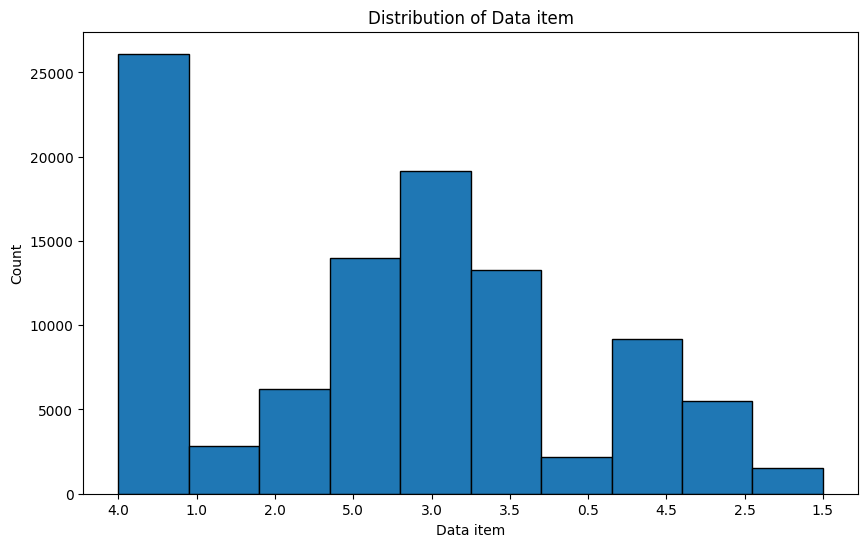

In [4]:
indexed_data.plot_data_item_distribution_as_hist(data_item="rating")

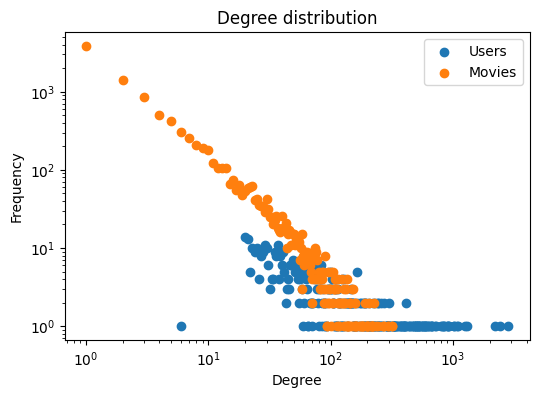

In [5]:
indexed_data.plot_power_low_distribution()

## Practical 2: biases only

In [6]:
data_by_user_id__train = SerialUnidirectionalMapper()
data_by_item_id__train = SerialUnidirectionalMapper()
data_by_user_id__test = SerialUnidirectionalMapper()
data_by_item_id__test = SerialUnidirectionalMapper()

visited_user_ids = set()
visited_movie_ids = set()

RATIO = 0.2
dataset_indices_based_representation = [
    (user_id, user_movie_id)
    for user_id in range(indexed_data.users_count)
    for user_movie_id in range(indexed_data.user_id_degree_map[user_id])
]

sample = random.sample(
    dataset_indices_based_representation,
    math.floor(len(dataset_indices_based_representation) * RATIO),
)

# TODO: List should be fine here
test_dataset_indices_based_representation = set(sample)

In [7]:
for user_id, user_movie_id in dataset_indices_based_representation:
    # Get the movie using the `user_movie_id`
    data = indexed_data.data_by_user_id[user_id][user_movie_id]
    rating, movie = data["rating"], data["movieId"]
    movie_id = indexed_data.id_to_item_bmap.inverse[movie]

    if (
        user_id,
        user_movie_id,
    ) in test_dataset_indices_based_representation:

        # We are having this user for the first time
        if user_id not in visited_user_ids:
            # Add the user and its first rating data
            data_by_user_id__test.add(
                indexed_data.data_by_user_id[user_id][user_movie_id]
            )
            # Add the user_id but with an empty array; this helps to ensure that
            # the test set and the training set will have the same dimension
            data_by_user_id__train.add(SerialUnidirectionalMapper.NOTHING)
            visited_user_ids.add(user_id)
        else:
            # The user has already been added
            data_by_user_id__test.add(
                indexed_data.data_by_user_id[user_id][user_movie_id], key=user_id
            )

        # DEAL WITH MOVIES

        if movie_id not in visited_movie_ids:
            data_by_item_id__test.add(
                {"userId": indexed_data.id_to_user_bmap[user_id], "rating": rating}
            )
            data_by_item_id__train.add(SerialUnidirectionalMapper.NOTHING)
            visited_movie_ids.add(movie_id)
        else:
            # The movie has already been added both in the training and the test dataset
            data_by_item_id__test.add(
                {"userId": indexed_data.id_to_user_bmap[user_id], "rating": rating},
                key=movie_id,
            )
    else:
        # We've got an occurrence that should be used as a training dataset
        if user_id not in visited_user_ids:

            data_by_user_id__train.add(
                indexed_data.data_by_user_id[user_id][user_movie_id]
            )
            # Add the user entry, but with an empty array
            data_by_user_id__test.add(SerialUnidirectionalMapper.NOTHING)
            visited_user_ids.add(user_id)
        else:
            data_by_user_id__train.add(
                indexed_data.data_by_user_id[user_id][user_movie_id], key=user_id
            )

        # DEAL WITH MOVIES

        if movie_id not in visited_movie_ids:
            data_by_item_id__test.add(SerialUnidirectionalMapper.NOTHING)

            data_by_item_id__train.add(
                {"userId": indexed_data.id_to_user_bmap[user_id], "rating": rating}
            )

            visited_movie_ids.add(movie_id)

        else:
            # The movie has already been added both in the training and the testing dataset
            data_by_item_id__train.add(
                {"userId": indexed_data.id_to_user_bmap[user_id], "rating": rating},
                key=movie_id,
            )

assert (
    len(visited_user_ids) == len(data_by_user_id__train) == len(data_by_user_id__test)
), "The user based matrix should have the save dimension both for the training dataset and the testing dataset. And that dimension should correspond to the visited users' count."

assert (
    len(visited_movie_ids) == len(data_by_item_id__train) == len(data_by_item_id__test)
), "The movie based matrix should have the save dimension both for the training dataset and the testing dataset. And that dimension should correspond to the visited movies' count."

assert sum(len(data_by_user_id__test[i]) for i in data_by_user_id__test) == math.floor(
    RATIO * LINES_COUNT_TO_READ
)

assert sum(
    len(data_by_user_id__train[i]) for i in data_by_user_id__train
) == math.floor((1 - RATIO) * LINES_COUNT_TO_READ)

In [8]:
N_EPOCH = 20
N_FACTOR = 10
NORMAL_DIST_MEAN = 0.0
NORMAL_DIST_STD = 1 / math.sqrt(N_FACTOR)
USER_FACTOR_SHAPE = (indexed_data.users_count, N_FACTOR)
ITEM_FACTOR_SHAPE = (indexed_data.items_count, N_FACTOR)
GAMMA = None

user_biases = np.zeros(len(data_by_user_id__train))
movie_biases = np.zeros(len(data_by_item_id__train))

In [9]:
mean_squared_errors_train = []
losses_train = []

mean_squared_errors_test = []
losses_test = []


def compute_iterative_losses_and_mse(
    lambda_hyper: float,
    gamma_hyper: float,
):
    n_users = len(data_by_user_id__train)
    n_movies = len(data_by_item_id__train)
    USER_FACTOR_SHAPE = (n_users, N_FACTOR)
    ITEM_FACTOR_SHAPE = (n_movies, N_FACTOR)
    TAU = 0.3
    user_factors = np.random.normal(
        loc=NORMAL_DIST_MEAN, scale=NORMAL_DIST_STD, size=USER_FACTOR_SHAPE
    )
    movie_factors = np.random.normal(
        loc=NORMAL_DIST_MEAN, scale=NORMAL_DIST_STD, size=ITEM_FACTOR_SHAPE
    )

    print("user_biases, item_biases, loss, rmse")

    """
    Consider this system of linear equations A * x = B.
    
    - A: Coefficient/System matrix.
    - x: Unknown vector (solution).
    - B: System constant or Constant vector (right-hand side).
    
    To solve the system, we use a numerical solver like np.linalg.solve(A, B),
    which returns the solution vector x.
    
    We will named A {something}_system_matrix and b {something}_system_constant.
    """

    # Learn the biases (the model) and compute the metrics at each iteration

    for iteration in range(N_EPOCH):

        for user_id in range(n_users):  # noqa
            bias = 0
            movies_count = 0

            for data in data_by_user_id__train[user_id]:
                movie, user_rating = data["movieId"], data["rating"]
                user_rating = float(user_rating)
                movie_id = indexed_data.id_to_item_bmap.inverse[movie]
                bias += lambda_hyper * (
                    user_rating
                    - movie_biases[movie_id]
                    - np.dot(user_factors[user_id], movie_factors[movie_id])
                )
                movies_count += 1
            bias /= (lambda_hyper * movies_count) + gamma_hyper

            user_biases[user_id] = bias
            # Compute the outer product
            user_system_matrix = np.zeros(
                (N_FACTOR, N_FACTOR)
            )  # Sum of user_factors' outer products
            user_system_constant = np.zeros(
                N_FACTOR
            )  # Sum of (r_ui - biases) * user_factors

            for data in data_by_user_id__train[user_id]:
                movie, user_rating = data["movieId"], data["rating"]
                user_rating = float(user_rating)
                movie_id = indexed_data.id_to_item_bmap.inverse[movie]
                item_factor = movie_factors[movie_id]
                user_system_matrix += np.outer(item_factor, item_factor)
                user_system_constant += (
                    user_rating - user_biases[user_id] - movie_biases[movie_id]
                ) * item_factor
            user_factors[user_id] = np.linalg.solve(
                lambda_hyper * user_system_matrix + TAU * np.eye(N_FACTOR),
                user_system_constant,
            )

        for movie_id in range(n_movies):  # noqa
            bias = 0
            users_count = 0
            movie_system_matrix = np.zeros(
                (N_FACTOR, N_FACTOR)
            )  # Sum of user_factors' outer products
            movie_system_constant = np.zeros(
                N_FACTOR
            )  # Sum of (r_ui - biases) * user_factors

            for data in data_by_item_id__train[movie_id]:
                user, movie_rating = data["userId"], data["rating"]  # noqa
                movie_rating = float(movie_rating)
                user_id = indexed_data.id_to_user_bmap.inverse[user]
                bias += lambda_hyper * (
                    movie_rating
                    - user_biases[user_id]
                    - np.dot(user_factors[user_id], movie_factors[movie_id])
                )
                users_count += 1
            bias /= (lambda_hyper * users_count) + gamma_hyper
            movie_biases[movie_id] = bias

            for data in data_by_item_id__train[movie_id]:
                user, movie_rating = data["userId"], data["rating"]
                movie_rating = float(movie_rating)
                user_idx = indexed_data.id_to_user_bmap.inverse[user]
                user_factor = user_factors[user_idx]
                movie_system_matrix += np.outer(user_factor, user_factor)
                movie_system_constant += (
                    movie_rating - user_biases[user_idx] - movie_biases[movie_id]
                ) * user_factor
            movie_factors[movie_id] = np.linalg.solve(
                lambda_hyper * movie_system_matrix + TAU * np.eye(N_FACTOR),
                movie_system_constant,
            )

        # Time to compute the metrics

        accumulated_residuals_train = 0
        residuals_count_train = 0

        # The metrics computation for the training dataset
        for user_id in range(n_users):  # noqa
            for data in data_by_user_id__train[user_id]:
                movie, movie_rating = data["movieId"], data["rating"]
                movie_rating = float(movie_rating)
                movie_id = indexed_data.id_to_user_bmap.inverse[movie]
                accumulated_residuals_train += (
                    movie_rating
                    - (
                        np.dot(user_factors[user_id], movie_factors[movie_id])
                        + movie_biases[indexed_data.id_to_item_bmap.inverse[movie]]
                        + user_biases[user_id]
                    )
                ) ** 2
                residuals_count_train += 1

        accumulated_residuals_test = 0
        residuals_count_test = 0

        # The metrics computation for the test dataset
        for user_id in range(n_users):  # noqa
            for data in data_by_user_id__test[user_id]:
                movie, movie_rating = data["movieId"], data["rating"]
                movie_rating = float(movie_rating)
                movie_id = indexed_data.id_to_item_bmap.inverse[movie]
                accumulated_residuals_test += (
                    movie_rating
                    - (
                        np.dot(user_factors[user_id], movie_factors[movie_id])
                        + movie_biases[movie_id]
                        + user_biases[user_id]
                    )
                ) ** 2
                residuals_count_test += 1

        loss_train = (-1 / 2 * (accumulated_residuals_train * lambda_hyper)) - TAU / 2
        losses_train.append((accumulated_residuals_train * lambda_hyper) / -2)
        mean_squared_errors_train.append(
            math.sqrt(accumulated_residuals_train / residuals_count_train)
        )

        losses_test.append((accumulated_residuals_test * lambda_hyper) / -2)
        mean_squared_errors_test.append(
            math.sqrt(accumulated_residuals_test / residuals_count_test)
        )

        print(
            f"Iteration Train {iteration} => MSE: ",
            math.sqrt(accumulated_residuals_train / residuals_count_train),
            "User bias: ",
            user_biases[0],
            "Movie bias: ",
            movie_biases[0],
            "Loss: ",
            accumulated_residuals_train * lambda_hyper / -2,
        )

In [10]:
indexed_data.id_to_item_bmap.inverse["17"]

0

In [11]:
# compute_iterative_losses_and_mse(
#    0.1, 0.01, indexed_data.data_by_user_id, indexed_data.data_by_item_id
# )

In [12]:
lambda_param = 0.1
gamma_param = 0.01
compute_iterative_losses_and_mse(lambda_param, gamma_param)

user_biases, item_biases, loss, rmse


ValueError: shapes (10,) and (1,10225,10) not aligned: 10 (dim 0) != 10225 (dim 1)

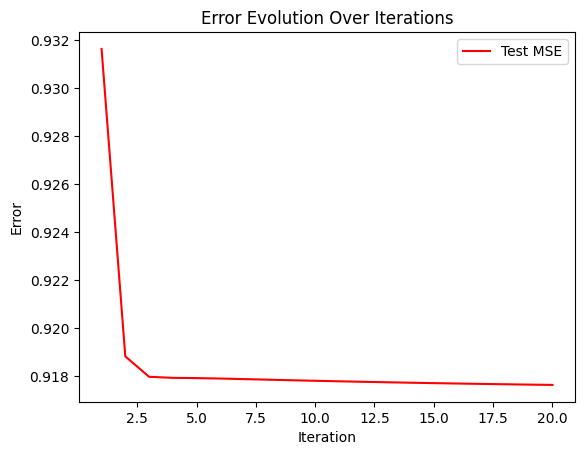

In [224]:
###############################################################

iterations = range(1, N_EPOCH + 1)

# Plotting mean squared error and alternating squared error

plt.plot(iterations, mean_squared_errors_test, label="Test MSE", color="red")

# Adding titles and labels
plt.title("Error Evolution Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Error")

# Show legend
plt.legend()

# Display the plot
plt.show()

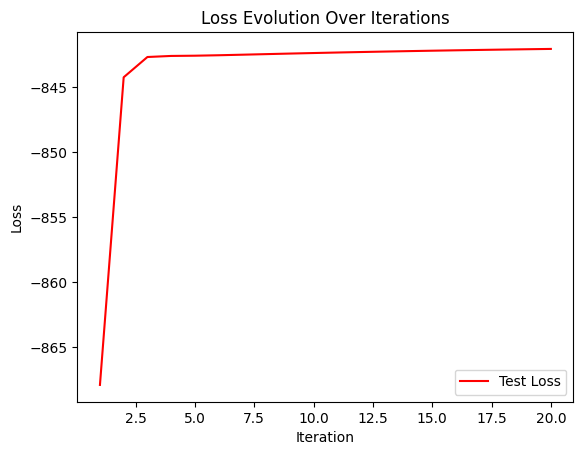

In [225]:
iterations = range(1, N_EPOCH + 1)

# Plotting mean squared error and alternating squared error

plt.plot(iterations, losses_test, label="Test Loss", color="red")

# Adding titles and labels
plt.title("Loss Evolution Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")

# Show legend
plt.legend()

# Display the plot
plt.show()

In [226]:
import numpy as np
from matplotlib import pyplot as plt

u = np.arange(-5, 5, 0.25)

In [227]:
v = np.arange(-5, 5, 0.25)

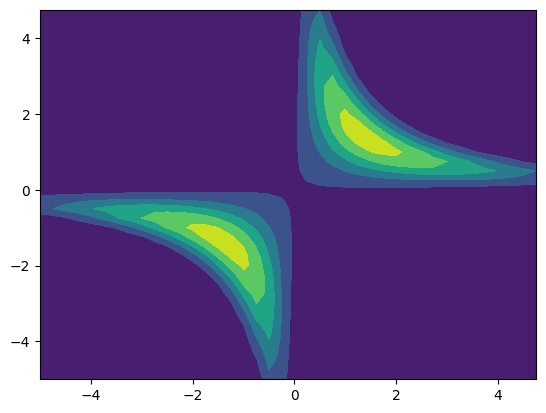

In [228]:
tau = 0.1
lambda_param = 1
r = 2
U, V = np.meshgrid(u, v)
P = (
    np.exp(-0.5 * lambda_param * ((r - (U * V)) ** 2))
    * np.exp(-0.5 * tau * (U**2))
    * np.exp(-0.5 * tau * (V**2))
)

surf = plt.contourf(U, V, P)